<a href="https://colab.research.google.com/github/stirlitzzz/markov_switching_demo/blob/main/MS_SPX_oecd_outofsample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%matplotlibh %cda inline

from datetime import datetime
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm

# NBER recessions
from pandas_datareader.data import DataReader

In [ ]:
#%%capture
#from tqdm import tqdm_notebook as tqdm
#tqdm().pandas()


In [ ]:
df_daily_data=pd.read_excel('SPY_prices_from_yahoo_combine.csv', index_col=0) 
df_data=df_daily_data.resample("W").first()
df_data

NameError: ignored

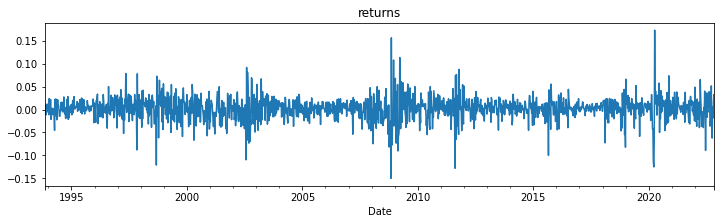

In [ ]:
df_data["return"]=df_data["Close"]/df_data["Close"].shift(periods=1)-1
df_returns=df_data["return"]
df_returns
df_returns.plot(title="returns", figsize=(12, 3))
df_diffusion_ind=df_data.diff_index_value


In [ ]:
from tqdm import tqdm
n_points=df_returns.size
sstart=np.math.floor(n_points/3)
#n_points=sstart+5

probs_out=[]
probs_tvtp_out=[]
models=[]
tvtp_models=[]

num_regimes=2
for j in range(num_regimes):
    regime_prob=[]
    regime_tvtp_prob=[]
    probs_out.append(regime_prob)
    probs_tvtp_out.append(regime_tvtp_prob)

with tqdm(total=len(range(sstart,n_points)), position=0, leave=True) as pbar:
    for i in tqdm (range(sstart,n_points), 
                desc="Loading…", 
                ascii=False, ncols=75,position=0, leave=True):
        mod_sm_fixed = sm.tsa.MarkovRegression(
            df_returns[1:i], k_regimes=num_regimes, trend="c", switching_variance=True, switching_trend=True)
        #print("i={}".format(i))
        res_fixed = mod_sm_fixed.fit()
        #res_fixed.summary()
        mod_sm_tvtp = sm.tsa.MarkovRegression(
            df_returns[1:i], k_regimes=num_regimes, trend="c", switching_variance=True, switching_trend=True,exog_tvtp=df_diffusion_ind[1:i])
        res_tvtp = mod_sm_tvtp.fit()
        models.append(res_fixed)
        tvtp_models.append(res_tvtp)
        #res_tvtp.summary()


        for j in range(num_regimes):
            probs=res_fixed.smoothed_marginal_probabilities[j]
            probs_tvtp=res_tvtp.smoothed_marginal_probabilities[j]
            probs_out[j].append(probs[-1])
            probs_tvtp_out[j].append(probs_tvtp[-1])
        #pbar.update()


Loading…:  22%|█████▍                   | 221/1010 [05:44<22:28,  1.71s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
Loading…:  23%|█████▋                   | 228/1010 [05:56<22:09,  1.70s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  0%|          | 0/1010 [32:52<?, ?it/s]


In [ ]:
df_data["SqReturn"]=np.power(df_data["return"],2)
vol=np.sqrt(df_data["SqReturn"].rolling(13).mean()*252/5)
vol_centered=vol.shift(periods=-6)
price_series=np.log(df_data["Close"])
type(vol_centered)
df_data.index

DatetimeIndex(['1993-11-07', '1993-11-14', '1993-11-21', '1993-11-28',
               '1993-12-05', '1993-12-12', '1993-12-19', '1993-12-26',
               '1994-01-02', '1994-01-09',
               ...
               '2022-09-04', '2022-09-11', '2022-09-18', '2022-09-25',
               '2022-10-02', '2022-10-09', '2022-10-16', '2022-10-23',
               '2022-10-30', '2022-11-06'],
              dtype='datetime64[ns]', name='Date', length=1514, freq='W-SUN')

process the regime probabilities into a time series


In [ ]:
#for x in probs_out:
#    x=pd.Series(df_data.index[sstart:],x)
#probs_out
probs_out_series=[pd.Series(x, index=df_data.index[sstart:]) for x in probs_out]
probs_tvtp_out_series=[pd.Series(x, index=df_data.index[sstart:]) for x in probs_tvtp_out]
#probs_out[1]=probs_out[1].tolist()


In [ ]:
res_tvtp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 return   No. Observations:                 1512
Model:               MarkovRegression   Log Likelihood                3613.211
Date:                Fri, 18 Nov 2022   AIC                          -7214.421
Time:                        17:46:02   BIC                          -7182.494
Sample:                    11-14-1993   HQIC                         -7202.532
                         - 10-30-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      6.058      0.000       0.002       0.004
sigma2         0.0002    1.7e-05     13.660      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.002     -0.938      0.348      -0.006       0.002
sigma2         0.0017      0.000     10.728      0.000       0.001       0.002
                           Regime transition parameters                          
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
p[0->0].tvtp0     6.8420      0.744      9.195      0.000       5.384       8.301
p[1->0].tvtp0    -4.1323      0.757     -5.458      0.000      -5.616      -2.648
=================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

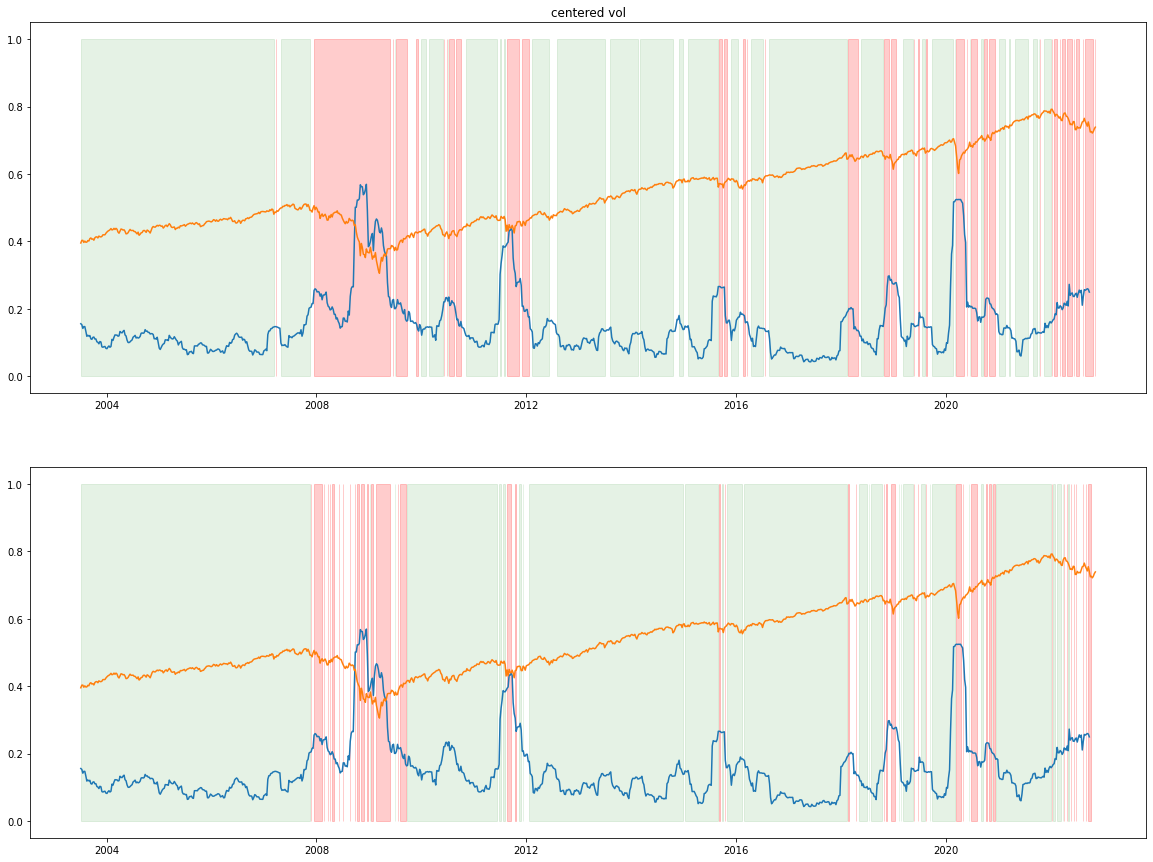

In [ ]:
fig, axes = plt.subplots(2, figsize=(20, 15))
ax = axes[0]
ax.plot(vol_centered[sstart:])
ax.plot((price_series[sstart:]-3)/4)
ax.plot()
#ax.fill_between(usrec.index, 0, 1, where=usrec["USREC"].values, color="k", alpha=0.1)
#ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title="centered vol")

#ax = axes[1]
#ax.plot(vol_centered[1:])
regime0_indicator=(probs_out_series[0]>.75)
regime1_indicator=(probs_out_series[1]>.75)
ax.fill_between(vol_centered[sstart:].index, 0, 1, where=regime0_indicator, color="g", alpha=0.1)
ax.fill_between(vol_centered[sstart:].index, 0, 1, where=regime1_indicator, color="r", alpha=0.2)

ax.set(title="centered vol")

ax = axes[1]
ax.plot(vol_centered[sstart:])
ax.plot((price_series[sstart:]-3)/4)

regime0_indicator_tvtp=(probs_tvtp_out_series[0]>.75)
regime1_indicator_tvtp=(probs_tvtp_out_series[1]>.75)
ax.fill_between(vol_centered[sstart:].index, 0, 1, where=regime0_indicator_tvtp, color="g", alpha=0.1)
ax.fill_between(vol_centered[sstart:].index, 0, 1, where=regime1_indicator_tvtp, color="r", alpha=0.2)

#ax.fill_between(vol_centered[1:].index, 0, 1, where=regime1_indicator_tvtp, color="k", alpha=0.1)

In [ ]:
tvtp_models[500].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 return   No. Observations:                 1003
Model:               MarkovRegression   Log Likelihood                2341.295
Date:                Fri, 18 Nov 2022   AIC                          -4670.590
Time:                        17:53:04   BIC                          -4641.126
Sample:                    11-14-1993   HQIC                         -4659.393
                         - 01-27-2013                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.501      0.000       0.001       0.004
sigma2         0.0004   2.25e-05     17.261      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.005     -1.016      0.309      -0.016       0.005
sigma2         0.0030      0.000      6.119      0.000       0.002       0.004
                           Regime transition parameters                          
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
p[0->0].tvtp0    11.6063      1.704      6.811      0.000       8.266      14.946
p[1->0].tvtp0    -4.6453      2.056     -2.259      0.024      -8.675      -0.615
=================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
import pickle
mylist = [models, tvtp_models]
with open('2_regime.txt', 'wb') as fh:
   pickle.dump(mylist, fh)

In [ ]:
pickle_off = open ("2_regime.txt", "rb")
emp = pickle.load(pickle_off)
print(emp)
[a, b]=emp

[[<statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper object at 0x7f40ed2a8e50>, <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper object at 0x7f40ed95a490>, <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper object at 0x7f40ec291710>, <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper object at 0x7f40edaa9c10>, <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper object at 0x7f40edaa9f10>, <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper object at 0x7f40ed84d350>, <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper object at 0x7f40eb7eab50>, <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper object at 0x7f40eb7f4dd0>, <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper object at 0x7f40ec1b04d0>, <statsmo

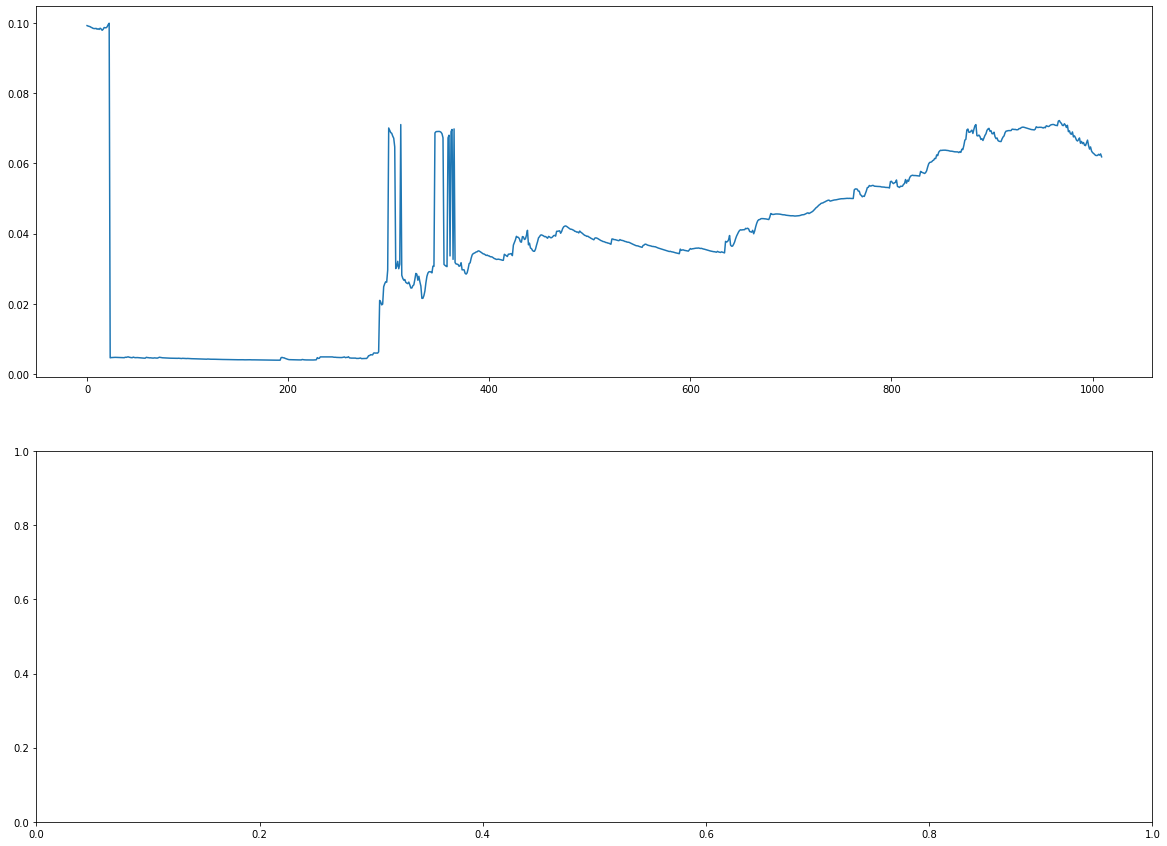

In [ ]:
bla=a[1]
dir(bla)
bla.regime_transition
transitions_zero_one=[x.regime_transition[0,1] for x in a]
transitions_zero_one

fig, axes = plt.subplots(2, figsize=(20, 15))
ax = axes[0]
ax.plot(transitions_zero_one)


In [ ]:
dir(bla)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_rank',
 '_use_t',
 'aic',
 'bic',
 'bse',
 'conditional_loglikelihoods',
 'conf_int',
 'cov_kwds',
 'cov_params',
 'cov_params_approx',
 'cov_params_default',
 'cov_params_opg',
 'cov_params_robust',
 'cov_type',
 'data',
 'expected_durations',
 'f_test',
 'filter_results',
 'filtered_joint_probabilities',
 'filtered_marginal_probabilities',
 'fittedvalues',
 'forecast',
 'hqic',
 'initial_probabilities',
 'initialize',
 'joint_likelihoods',
 'joint_loglikelihoods',
 'k_constant